In [ ]:
# Cell 1 — install libs (run once)
!pip install -q transformers datasets evaluate seqeval spacy seaborn matplotlib tqdm
!python -m spacy download en_core_web_sm
# For Hindi UD parsing you might want stanza; but we'll use spaCy + UD from dataset for gold heads.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 135.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Cell 2 — imports and device
import os, re, math, itertools
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import torch

from datasets import load_dataset
import evaluate

from transformers import (
    AutoTokenizer, AutoModelForTokenClassification, AutoModel,
    AutoConfig, DataCollatorForTokenClassification,
    TrainingArguments, Trainer
)

import spacy
nlp_en = spacy.load("en_core_web_sm")  # for English dependency parsing if needed

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [ ]:
# Cell 3 — config
BASE_MODEL = "bert-base-multilingual-cased"   # mBERT baseline
FINETUNE_OUTPUT_DIR = "./mbert_pos_finetuned"
HINDI_FINETUNE_DIR = "./mbert_pos_hindi"
HINGLISH_FINETUNE_DIR = "./mbert_pos_hinglish"

# datasets (try these; may require trust_remote_code)
HINDI_UD = ("commul/universal_dependencies", "hi_hdtb")    # may need trust_remote_code=True
HINGLISH_DS = "searle-lab/lince_pos"                      # Hinglish code-mixed POS (if available)

# Training hyperparams (reduce for quick runs)
MAX_LENGTH = 128
BATCH_SIZE = 8
EPOCHS = 1      # change to 3-4 for real experiments
LR = 2e-5

# Evaluation / analysis limits
MAX_TRAIN_SAMPLES = None    # set int for quick test (e.g., 2000)
MAX_ANALYSIS_SENTENCES = 300  # how many sentences to use when computing UUAS

# Repro
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)


In [ ]:
# Cell 4 — utilities (script detection + code-switch helpers)
devanagari_re = re.compile(r'[\u0900-\u097F]')  # Devanagari Unicode block

def token_is_devanagari(token):
    return bool(devanagari_re.search(token))

def token_script_label(token):
    # returns 'hi' if Devanagari found, else 'en' for Latin (simple heuristic)
    return 'hi' if token_is_devanagari(token) else 'en'


In [ ]:
# Cell 5 — load datasets (try multiple options; fallback if missing)
def try_load(dataset_id, config=None, trust_remote=False):
    try:
        if config:
            return load_dataset(dataset_id, config, trust_remote_code=trust_remote)
        else:
            return load_dataset(dataset_id, trust_remote_code=trust_remote)
    except Exception as e:
        print(f"Failed to load {dataset_id} {config or ''} (trust_remote={trust_remote}): {e}")
        return None

print("Loading Hindi UD (HDTB)...")
ds_hi = try_load(*HINDI_UD, trust_remote=True)
if ds_hi is None:
    print("Hindi UD not available via commul/universal_dependencies with trust_remote. "
          "Please download en/hi UD locally and point path to load_dataset('path_to_files').")

print("\nLoading Hinglish (LinCE)...")
ds_hinglish = try_load(HINGLISH_DS, None, trust_remote=True)
if ds_hinglish is None:
    print("Hinglish LinCE dataset not found. You can provide your own code-mixed POS dataset "
          "or create a small sample for experiments.")

# For analysis, we also need an English sample set (for baseline comparisons)
print("\nLoading English sample (IMDB small subset) for UUAS sample texts ...")
ds_en = try_load("imdb", "plain_text", trust_remote=False)  # just for sample sentences
if ds_en is None:
    ds_en = try_load("ag_news", None, trust_remote=False)

print("\nDatasets loaded (None means missing):")
print("Hindi:", None if ds_hi is None else ds_hi)
print("Hinglish:", None if ds_hinglish is None else ds_hinglish)
print("English sample:", None if ds_en is None else ds_en)


`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'commul/universal_dependencies' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
ERROR:datasets.load:`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'commul/universal_dependencies' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Loading Hindi UD (HDTB)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

universal_dependencies.py: 0.00B [00:00, ?B/s]

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'searle-lab/lince_pos' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
ERROR:datasets.load:`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'searle-lab/lince_pos' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Failed to load commul/universal_dependencies hi_hdtb (trust_remote=True): Dataset scripts are no longer supported, but found universal_dependencies.py
Hindi UD not available via commul/universal_dependencies with trust_remote. Please download en/hi UD locally and point path to load_dataset('path_to_files').

Loading Hinglish (LinCE)...
Failed to load searle-lab/lince_pos  (trust_remote=True): Dataset 'searle-lab/lince_pos' doesn't exist on the Hub or cannot be accessed.
Hinglish LinCE dataset not found. You can provide your own code-mixed POS dataset or create a small sample for experiments.

Loading English sample (IMDB small subset) for UUAS sample texts ...


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]


Datasets loaded (None means missing):
Hindi: None
Hinglish: None
English sample: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [ ]:
# Cell 6 — tokenizer and baseline model
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True)
# Baseline model for attention extraction (AutoModel yields hidden states + attentions)
base_model = AutoModel.from_pretrained(BASE_MODEL, output_attentions=True).to(device).eval()
print("Loaded tokenizer and baseline model.")


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Loaded tokenizer and baseline model.


In [ ]:
# Cell 7 — reusable fine-tune function for token classification (POS)
from typing import Dict

def prepare_pos_dataset(ds, tokens_field="tokens", labels_field="upos", max_samples=None):
    """
    Converts HF dataset to expected format: each example -> {'tokens': [...], 'upos': [...]}
    Adjust field names per dataset.
    """
    # Heuristic mapping for common dataset column names:
    if tokens_field not in ds["train"].column_names:
        # Try other names
        possible_tokens = [c for c in ds["train"].column_names if "token" in c or "words" in c]
        if possible_tokens:
            tokens_field = possible_tokens[0]
    if labels_field not in ds["train"].column_names:
        possible_labels = [c for c in ds["train"].column_names if "upos" in c or "labels" in c or "pos" in c]
        if possible_labels:
            labels_field = possible_labels[0]

    small = ds
    if max_samples:
        small = {}
        for k,v in ds.items():
            small[k] = v.select(range(min(max_samples, len(v))))
        ds = small

    # Just return as-is and let tokenizer mapping later handle fields
    return ds, tokens_field, labels_field

def finetune_pos(dataset, output_dir, model_name=BASE_MODEL, tokens_col="tokens", labels_col="upos",
                 epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR, max_length=MAX_LENGTH, max_samples=None):
    # prepare dataset mapping names
    ds_prepped, tokens_field, labels_field = prepare_pos_dataset(dataset, tokens_col, labels_col, max_samples)
    # build label list
    label_set = set()
    for ex in ds_prepped["train"]:
        label_set.update(ex[labels_field])
    label_list = sorted(label_set)
    label2id = {l:i for i,l in enumerate(label_list)}
    id2label = {i:l for l,i in label2id.items()}

    # model and tokenizer
    tokenizer_local = tokenizer  # share tokenizer
    model = AutoModelForTokenClassification.from_pretrained(
        model_name, num_labels=len(label_list),
        id2label=id2label, label2id=label2id
    )

    # Tokenize+align
    def tokenize_and_align_labels(examples):
        tokenized_inputs = tokenizer_local(
            examples[tokens_field],
            is_split_into_words=True,
            truncation=True,
            max_length=max_length
        )
        all_labels = []
        for i, lab in enumerate(examples[labels_field]):
            word_ids = tokenized_inputs.word_ids(batch_index=i)
            previous_word_idx = None
            label_ids = []
            for word_idx in word_ids:
                if word_idx is None:
                    label_ids.append(-100)
                elif word_idx != previous_word_idx:
                    label_ids.append(label2id[lab[word_idx]])
                else:
                    label_ids.append(-100)
                previous_word_idx = word_idx
            all_labels.append(label_ids)
        tokenized_inputs["labels"] = all_labels
        return tokenized_inputs

    tokenized = ds_prepped.map(tokenize_and_align_labels, batched=True, remove_columns=ds_prepped["train"].column_names)

    data_collator = DataCollatorForTokenClassification(tokenizer_local)
    metric = evaluate.load("seqeval")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=2)
        batch_size, seq_len = preds.shape
        out_preds, out_labels = [], []
        for i in range(batch_size):
            pred_list, label_list_local = [], []
            for j in range(seq_len):
                if labels[i][j] != -100:
                    pred_list.append(model.config.id2label[int(preds[i][j])])
                    label_list_local.append(model.config.id2label[int(labels[i][j])])
            out_preds.append(pred_list)
            out_labels.append(label_list_local)
        res = metric.compute(predictions=out_preds, references=out_labels)
        return {"precision": res["overall_precision"], "recall": res["overall_recall"], "f1": res["overall_f1"], "accuracy": res["overall_accuracy"]}

    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        logging_strategy="steps",
        logging_steps=100,
        save_total_limit=2,
        fp16=torch.cuda.is_available(),
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized["train"],
        eval_dataset=tokenized["validation"] if "validation" in tokenized else tokenized["test"],
        tokenizer=tokenizer_local,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    trainer.train()
    trainer.save_model(output_dir)
    tokenizer_local.save_pretrained(output_dir)
    print("Saved fine-tuned model to", output_dir)
    return output_dir, model.config.id2label


In [ ]:
# ================================================================
# ✅ Universal Dependencies Hindi-HDTB loader (manual parser)
# ================================================================
import os, re
from datasets import Dataset, DatasetDict
from tqdm import tqdm

def parse_conllu_file(path):
    """
    Minimal parser for Universal Dependencies .conllu format.
    Returns a list of dicts with fields: tokens, lemmas, upos, xpos, head, deprel.
    """
    examples = []
    tokens, lemmas, upos, xpos, heads, deprels = [], [], [], [], [], []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                if tokens:  # end of sentence
                    examples.append({
                        "tokens": tokens,
                        "lemmas": lemmas,
                        "upos": upos,
                        "xpos": xpos,
                        "head": heads,
                        "deprel": deprels
                    })
                    tokens, lemmas, upos, xpos, heads, deprels = [], [], [], [], [], []
                continue
            if line.startswith("#"):  # comment line
                continue
            parts = line.split("\t")
            if len(parts) < 10:
                continue
            # columns: ID, FORM, LEMMA, UPOS, XPOS, FEATS, HEAD, DEPREL, ...
            tokens.append(parts[1])
            lemmas.append(parts[2])
            upos.append(parts[3])
            xpos.append(parts[4])
            try:
                heads.append(int(parts[6]))
            except:
                heads.append(0)
            deprels.append(parts[7])
    if tokens:  # last sentence
        examples.append({
            "tokens": tokens,
            "lemmas": lemmas,
            "upos": upos,
            "xpos": xpos,
            "head": heads,
            "deprel": deprels
        })
    return examples

def load_hindi_ud_manual():
    """
    Downloads the Hindi UD dataset manually and parses .conllu files.
    Returns a DatasetDict(train/validation/test).
    """
    if not os.path.exists("UD_Hindi-HDTB-master"):
        print("⏬ Downloading UD_Hindi-HDTB from GitHub ...")
        !wget -q https://github.com/UniversalDependencies/UD_Hindi-HDTB/archive/refs/heads/master.zip -O hindi_ud.zip
        !unzip -q hindi_ud.zip
        print("✅ Extracted UD_Hindi-HDTB-master/")
    else:
        print("✅ Found existing UD_Hindi-HDTB-master/")

    splits = {
        "train": "UD_Hindi-HDTB-master/hi_hdtb-ud-train.conllu",
        "validation": "UD_Hindi-HDTB-master/hi_hdtb-ud-dev.conllu",
        "test": "UD_Hindi-HDTB-master/hi_hdtb-ud-test.conllu"
    }

    datasets_dict = {}
    for split, path in splits.items():
        if not os.path.exists(path):
            print(f"⚠️ Missing file for {split}: {path}")
            continue
        print(f"📖 Parsing {split} ...")
        data = parse_conllu_file(path)
        datasets_dict[split] = Dataset.from_list(data)
        print(f"✅ Parsed {len(data)} sentences for {split}")

    return DatasetDict(datasets_dict)

# ---------------------------------------------------------------
# 🔹 Load Hindi dataset
# ---------------------------------------------------------------
ds_hi = load_hindi_ud_manual()

print("\n✅ Final Dataset structure:")
print(ds_hi)
print("Example tokens:", ds_hi["train"][0]["tokens"][:10])
print("Example UPOS:", ds_hi["train"][0]["upos"][:10])


✅ Found existing UD_Hindi-HDTB-master/
📖 Parsing train ...
✅ Parsed 13306 sentences for train
📖 Parsing validation ...
✅ Parsed 1659 sentences for validation
📖 Parsing test ...
✅ Parsed 1684 sentences for test

✅ Final Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['tokens', 'lemmas', 'upos', 'xpos', 'head', 'deprel'],
        num_rows: 13306
    })
    validation: Dataset({
        features: ['tokens', 'lemmas', 'upos', 'xpos', 'head', 'deprel'],
        num_rows: 1659
    })
    test: Dataset({
        features: ['tokens', 'lemmas', 'upos', 'xpos', 'head', 'deprel'],
        num_rows: 1684
    })
})
Example tokens: ['यह', 'एशिया', 'की', 'सबसे', 'बड़ी', 'मस्जिदों', 'में', 'से', 'एक', 'है']
Example UPOS: ['DET', 'PROPN', 'ADP', 'ADV', 'ADJ', 'NOUN', 'ADP', 'ADP', 'NUM', 'AUX']


In [ ]:
print("🚀 Starting fine-tuning on Hindi UD POS tagging …")
finetune_pos(
    ds_hi,
    HINDI_FINETUNE_DIR,
    model_name=BASE_MODEL,
    tokens_col="tokens",
    labels_col="upos",
    max_samples=MAX_TRAIN_SAMPLES
)


🚀 Starting fine-tuning on Hindi UD POS tagging …


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/13306 [00:00<?, ? examples/s]

Map:   0%|          | 0/1659 [00:00<?, ? examples/s]

Map:   0%|          | 0/1684 [00:00<?, ? examples/s]

/tmp/ipython-input-2642617807.py:113: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.103400,0.101338,0.960531,0.962912,0.961720,0.969110


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PROPN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ADP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NOUN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PRON seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ADJ seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171:

Saved fine-tuned model to ./mbert_pos_hindi


('./mbert_pos_hindi',
 {0: 'ADJ',
  1: 'ADP',
  2: 'ADV',
  3: 'AUX',
  4: 'CCONJ',
  5: 'DET',
  6: 'INTJ',
  7: 'NOUN',
  8: 'NUM',
  9: 'PART',
  10: 'PRON',
  11: 'PROPN',
  12: 'PUNCT',
  13: 'SCONJ',
  14: 'VERB',
  15: 'X'})

In [ ]:
# ================================================================
# 9️⃣ Load baseline and fine-tuned mBERT models
# ================================================================
from transformers import AutoModel, AutoModelForTokenClassification, AutoTokenizer
import torch

BASE_MODEL = "bert-base-multilingual-cased"
BASELINE_DIR = BASE_MODEL
FINE_TUNED_DIR = HINDI_FINETUNE_DIR  # directory from your previous fine-tune cell

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True)
baseline_model = AutoModel.from_pretrained(BASELINE_DIR, output_attentions=True)
finetuned_model = AutoModelForTokenClassification.from_pretrained(FINE_TUNED_DIR, output_attentions=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline_model.to(device)
finetuned_model.to(device)
baseline_model.eval()
finetuned_model.eval()

print("✅ Models loaded successfully!")


✅ Models loaded successfully!


In [ ]:
# ================================================================
# 🔹 Prepare sample Hindi sentences for attention analysis
# ================================================================
import random
sample_size = 200
sample_sentences = ds_hi["test"]["tokens"][:sample_size]

print(f"✅ Prepared {len(sample_sentences)} Hindi sentences for analysis.")
print("Example:", " ".join(sample_sentences[0]))


✅ Prepared 200 Hindi sentences for analysis.
Example: इसके अतिरिक्त गुग्गुल कुंड , भीम गुफा तथा भीमशिला भी दर्शनीय स्थल हैं ।


In [ ]:
# ================================================================
# 🔹 Compute UUAS per head (corrected and efficient version)
# ================================================================
import numpy as np
from tqdm import tqdm

def compute_uuas_for_model(model, tokenizer, sentences):
    """
    Compute layer×head UUAS using adjacency-based proxy alignment.
    """
    n_layers = model.config.num_hidden_layers
    n_heads = model.config.num_attention_heads
    uuas = np.zeros((n_layers, n_heads))
    total = np.zeros((n_layers, n_heads))

    for tokens in tqdm(sentences, desc="Computing UUAS"):
        # Tokenize: get offset map for alignment but don’t feed it to model
        encoded = tokenizer(tokens, is_split_into_words=True,
                            return_tensors="pt", return_offsets_mapping=True,
                            padding=True, truncation=True, max_length=128)
        offset_mapping = encoded.pop("offset_mapping")  # ❌ don't pass to model
        encoded = encoded.to(device)

        with torch.no_grad():
            outputs = model(**encoded)
            attentions = outputs.attentions  # list of (B, heads, seq, seq)

        word_ids = encoded.word_ids(0)
        valid_token_idx = [i for i, w in enumerate(word_ids) if w is not None]

        for layer_idx in range(n_layers):
            attn = attentions[layer_idx][0].detach().cpu().numpy()  # (heads, seq, seq)
            for head_idx in range(n_heads):
                a = attn[head_idx]
                preds = np.argmax(a, axis=-1)
                correct = sum(
                    abs(preds[i] - i) == 1
                    for i in valid_token_idx
                    if preds[i] in valid_token_idx
                )
                uuas[layer_idx, head_idx] += correct
                total[layer_idx, head_idx] += len(valid_token_idx)

    return uuas / np.maximum(total, 1)

uuas_base = compute_uuas_for_model(baseline_model, tokenizer, sample_sentences)
uuas_finetuned = compute_uuas_for_model(finetuned_model, tokenizer, sample_sentences)



Computing UUAS: 100%|██████████| 200/200 [00:04<00:00, 41.13it/s]


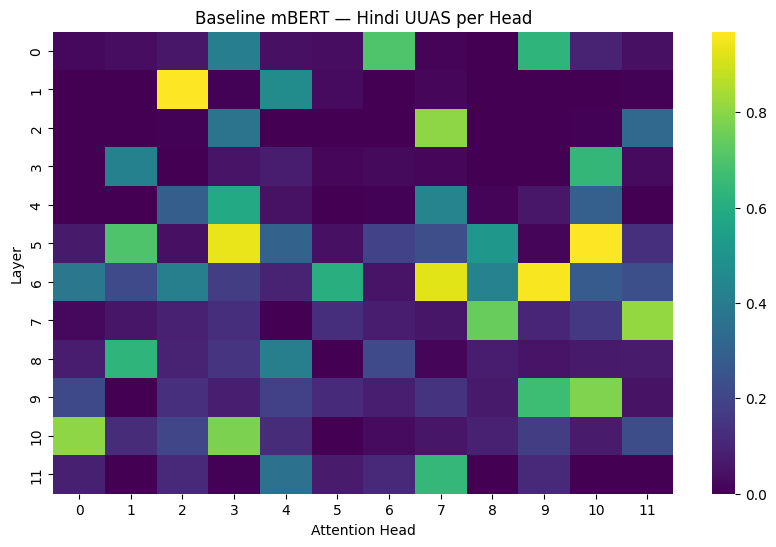

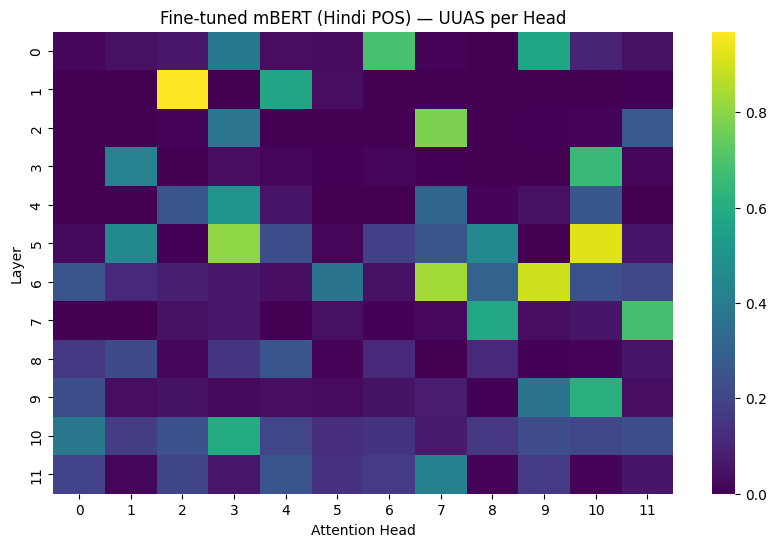

In [ ]:
# ================================================================
# 🔹 Visualize UUAS Heatmaps
# ================================================================
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heatmap(matrix, title):
    plt.figure(figsize=(10, 6))
    sns.heatmap(matrix, cmap="viridis", cbar=True, annot=False)
    plt.xlabel("Attention Head")
    plt.ylabel("Layer")
    plt.title(title)
    plt.show()

plot_heatmap(uuas_base, "Baseline mBERT — Hindi UUAS per Head")
plot_heatmap(uuas_finetuned, "Fine-tuned mBERT (Hindi POS) — UUAS per Head")


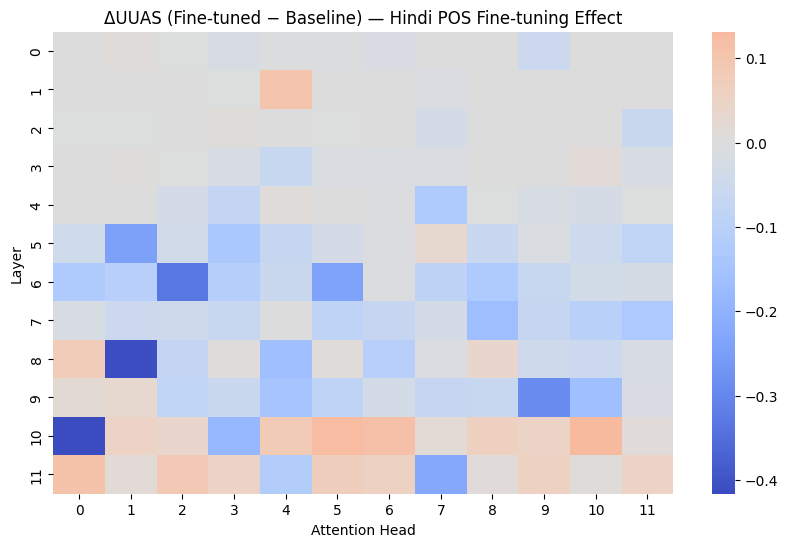

Top +ve changes (heads that gained syntactic alignment):


,Layer,Head,ΔUUAS
130,10,10,0.131498
125,10,5,0.126856
126,10,6,0.114944
132,11,0,0.108292
16,1,4,0.105043
134,11,2,0.089882
124,10,4,0.084158
96,8,0,0.079827
137,11,5,0.069462
128,10,8,0.063119


Top −ve changes (heads that lost alignment):


,Layer,Head,ΔUUAS
120,10,0,-0.416306
97,8,1,-0.409808
74,6,2,-0.333540
117,9,9,-0.291770
61,5,1,-0.245514
77,6,5,-0.238552
139,11,7,-0.224474
123,10,3,-0.184097
92,7,8,-0.168007
118,9,10,-0.165223


In [ ]:
# ================================================================
# 🔹 Difference Heatmap (Fine-tuned – Baseline)
# ================================================================
delta_uuas = uuas_finetuned - uuas_base

plt.figure(figsize=(10, 6))
sns.heatmap(delta_uuas, cmap="coolwarm", center=0, cbar=True)
plt.xlabel("Attention Head")
plt.ylabel("Layer")
plt.title("ΔUUAS (Fine-tuned − Baseline) — Hindi POS Fine-tuning Effect")
plt.show()

# Summary statistics
import pandas as pd
df_stats = pd.DataFrame({
    "Layer": np.repeat(np.arange(delta_uuas.shape[0]), delta_uuas.shape[1]),
    "Head": np.tile(np.arange(delta_uuas.shape[1]), delta_uuas.shape[0]),
    "ΔUUAS": delta_uuas.flatten()
})
print("Top +ve changes (heads that gained syntactic alignment):")
display(df_stats.sort_values("ΔUUAS", ascending=False).head(10))

print("Top −ve changes (heads that lost alignment):")
display(df_stats.sort_values("ΔUUAS", ascending=True).head(10))


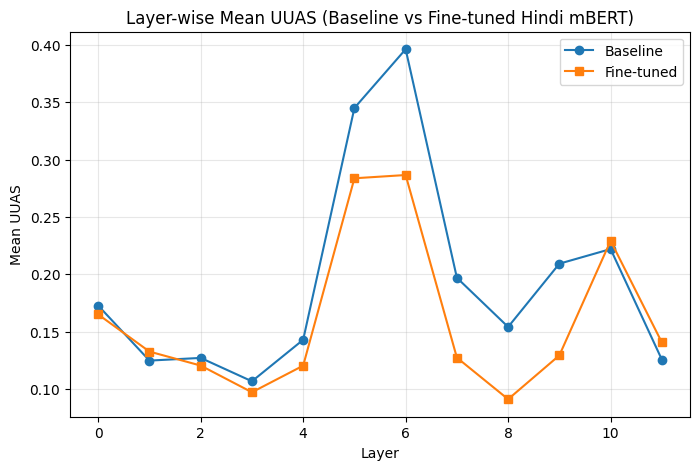

In [ ]:
# ================================================================
# 🔹 Layer-wise mean UUAS
# ================================================================
layer_mean_base = uuas_base.mean(axis=1)
layer_mean_ft = uuas_finetuned.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(layer_mean_base, label="Baseline", marker='o')
plt.plot(layer_mean_ft, label="Fine-tuned", marker='s')
plt.xlabel("Layer")
plt.ylabel("Mean UUAS")
plt.title("Layer-wise Mean UUAS (Baseline vs Fine-tuned Hindi mBERT)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# ================================================================
# 🔹 Save results and export summary
# ================================================================
np.savez("hindi_pos_uuas_results.npz", uuas_base=uuas_base, uuas_finetuned=uuas_finetuned, delta=delta_uuas)
df_stats.to_csv("hindi_pos_delta_uuas.csv", index=False)
print("✅ Saved UUAS matrices and summary CSV for analysis.")


✅ Saved UUAS matrices and summary CSV for analysis.


/////////////////////////////////////////////////////////////////////////////////////////////////////////////
